# Wavelet toy-model

This tutorial goes through the same example as the Quickstart Guide but shows how to use `WaveletSource` instead of pixelated sources.

In [8]:
# Import Packages and setup
import numpy as np
import scarlet
import astropy.io.fits as fits
import sep 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a superior colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern', interpolation='none')

## Load and Display Data

We load an example data set (here an image cube with 5 bands) *and* a detection catalog.
If such a catalog is not available packages like [SEP](http://sep.readthedocs.io/) and [photutils](https://photutils.readthedocs.io/en/stable/) will happily generate one, but for this example we use part of the detection catalog generated by the [LSST DM stack](https://github.com/lsst). 

In [9]:
# Load the sample images
images = fits.open('../../data/hsc_ra=150.24071_dec=2.06514.fits')[0].data
filters = ['g','r','i','z','y']
psfs = fits.open('../../data/psf_hsc_ra=150.24071_dec=2.06514.fits')[0].data

Here we detect the sources in the image and build a catalog of sources to deblend

In [13]:
def makeCatalog(datas, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=4).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] + wave_detect[0][2]
        else:
            detect = detect_image

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)

    if type(datas) is np.ndarray:
        bg_rms = scarlet.wavelet.mad_wavelet(datas)
    else:
        bg_rms = []
        for data in datas:
            bg_rms.append(scarlet.wavelet.mad_wavelet(data.images))

    return catalog, bg_rms
#Detection and background noise estimate
catalog, bg_rms_hsc = makeCatalog(images, 1, 1)

weights = np.ones_like(images) / (bg_rms_hsc**2)[:, None, None]

This shows how the wavelet transform and inverse transform works in scarlet. As a check we make sure that the transform and its inverse lead to the original image.

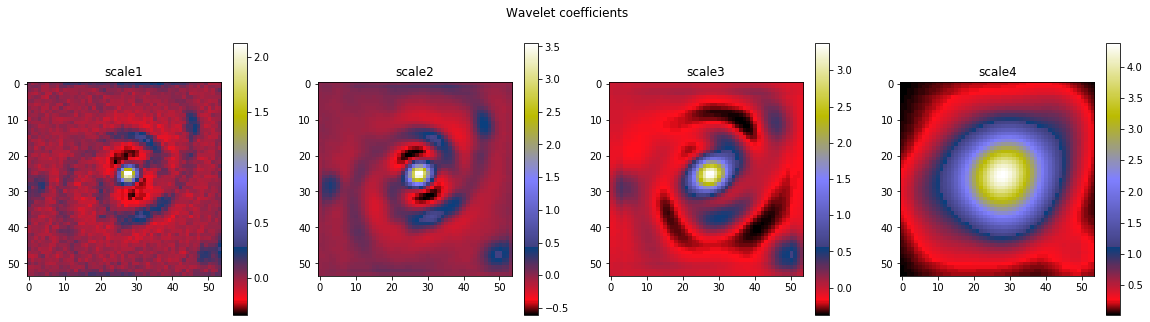

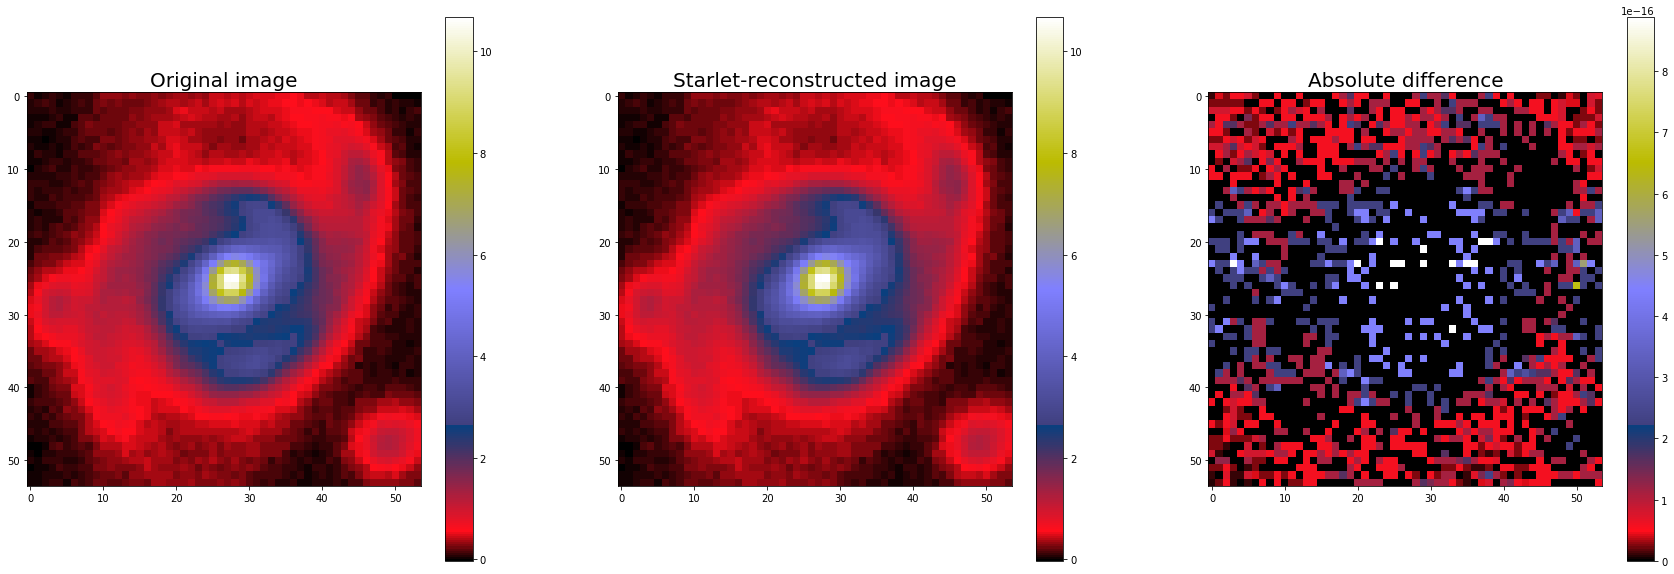

In [14]:
#Declare a starlet object (and performs the transform)
Sw = scarlet.Starlet(images, lvl = 4, direct = True)
#This is the starlet transform as an array
w = Sw.coefficients
#The inverse starlet transform of w (new object otherwise, the tranform is not used)
iw = Sw.image

#The wavelet transform of the first slice of images in pictures:
lvl = w.shape[1]
plt.figure(figsize = (lvl*5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    plt.imshow(w[0,i])
    plt.colorbar()
plt.show()

#Making sure we recover the original image:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.title('Original image', fontsize = 20)
plt.imshow(images[0])
plt.colorbar()
plt.subplot(132)
plt.title('Starlet-reconstructed image', fontsize = 20)
plt.imshow(iw[0])
plt.colorbar()
plt.subplot(133)
plt.title('Absolute difference', fontsize = 20)
plt.imshow((np.abs(iw[0]-images[0])))
plt.colorbar()
plt.show()

### A word on starlets

Starlets are a familly of functions that are generative of the ensemble of real matrices of finite sahpes and overcomplete. In that regard, shapelets have the flexibility to represent any pixelated 2-D profile. We take advantage of this property and use starlets to model sources with features that are too complex to be modeled with only assumptions of symmetry or monotonicity, such as irregular galaxies and spiral galaxies.


### Display Image Cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sinh^{-1}$ function to normalize the flux in each filter consistently to create an RGB image.

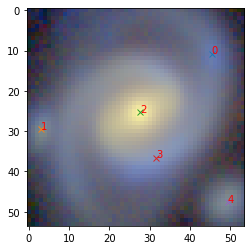

In [15]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="red")
    plt.plot(src["x"], src["y"], 'x')

Looking at the detected sources, it seems that sources 1 and 4 are individual components, while the central galaxy has a "red" component centered around 2 and a blue component particularly bright around 3 and 0. We will use this information to inform the choice of source types we use to model the scene.

Here this procedure is done manually, but in the future, we expect that matching images with different colours and complex morphologies might help automating this process.

## Define Model Frame and Observation

With this we can fully specify the `Frame` and `Observation`:

In [16]:
model_frame = scarlet.Frame(
    images.shape,
    psfs=psfs,
    channels=filters)

observation = scarlet.Observation(
    images, 
    psfs=psfs, 
    weights=weights, 
    channels=filters).match(model_frame)

## Initialize sources

You now need to define sources that are going to be fit. The full model, which we will call `Blend`, is a collection of those sources. Has mentioned previously, we chose to represent components 1 and 4 as `ExtendedSources`, while the rest of the scene is modeled by 2 `StarletSources` with different colours:

In [17]:

sources = []
for k,src in enumerate(catalog):
    if k in [2,0]:
        new_source = scarlet.StarletSource(model_frame, 
                        (src["x"], src["y"]), observation, 
                        starlet_thresh = 1)
        sources.append(new_source)
    if k in [4,1]:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation)
        sources.append(new_source)

## Create and Fit Model
The `Blend` class represents the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

CPU times: user 11.8 s, sys: 157 ms, total: 12 s
Wall time: 12.1 s
scarlet ran for 200 iterations to logL = -11880.464685876846


Text(0, 0.5, 'log-Likelihood')

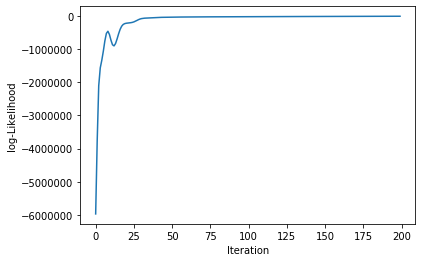

In [18]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200, e_rel=1e-4)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

## Interact with Results

### View Full Scene

We will use `scarlet.display.show_scene` to render the entire scene. We then show model and data with the same $sinh^{-1}$ stretch and the residuals with a linear stretch.

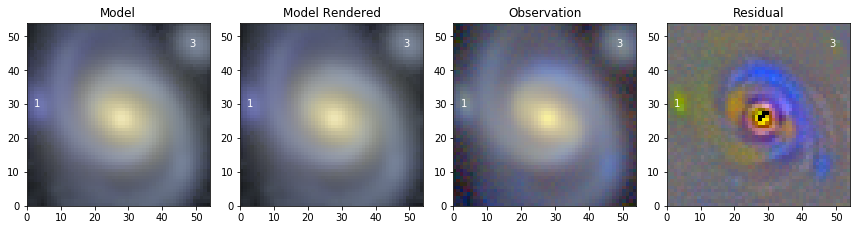

In [19]:
scarlet.display.show_scene(sources, 
                           norm=norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True,
                           add_boxes=True,
                          )
plt.show()

### View Source Models

We will now inspect the model for each source, in its original frame and in its observed frame by leveraging the `show_sources` method:

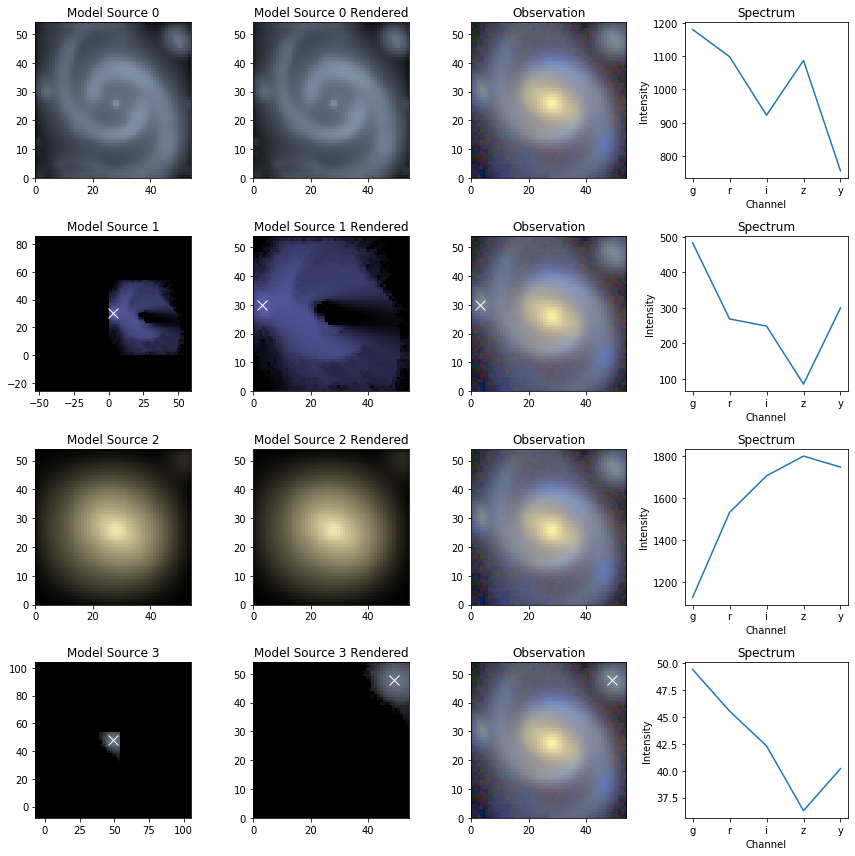

In [20]:
scarlet.display.show_sources(sources, 
                             norm=norm, 
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True,
                             add_boxes=True
                            )
plt.show()